<a href="https://colab.research.google.com/github/JuniusKareth/TugasDLTM4/blob/master/running_epoch100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive

drive.mount ('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import math                      # providing access to the mathematical functions defined by the C standard
import matplotlib.pyplot as plt  # plotting library
import scipy                     # scientific computnig and technical computing
import cv2                       # working with, mainly resizing, images
import numpy as np               # dealing with arrays
import glob                      # return a possibly-empty list of path names that match pathname
import os                        # dealing with directories
import pandas as pd              # providing data structures and data analysis tools
import tensorflow as tf
import itertools
import random
from random import shuffle       # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm            # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion
from PIL import Image
from scipy import ndimage
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
%matplotlib inline
np.random.seed(1)

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
train_dir = Path('/content/gdrive/MyDrive/10-Monkey-Species/training/training')
test_dir = Path('/content/gdrive/MyDrive/10-Monkey-Species/validation/validation')

In [5]:
#label info
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("/content/gdrive/MyDrive/10-Monkey-Species/monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [6]:
labels = labels['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [7]:
def image_show(num_image,label):
    for i in range(num_image):
        imgdir = Path('/content/gdrive/MyDrive/10-Monkey-Species/training/training/' + label)
        #print(imgdir)
        imgfile = random.choice(os.listdir(imgdir))
        #print(imgfile)
        img = cv2.imread('/content/gdrive/MyDrive/10-Monkey-Species/training/training'+ label +'/'+ imgfile)
       # print(img.shape)
        #print(label)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()

In [8]:
LR = 1e-3
height=150
width=150
channels=3
seed=1337
batch_size = 64
num_classes = 10
epochs = 200
data_augmentation = True
num_predictions = 20

# Training generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(height,width),
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

train_num = train_generator.samples
validation_num = validation_generator.samples

Found 1113 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                   

In [11]:
filepath=str(os.getcwd()+"/model.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint]#, stopper]

In [12]:
history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs= 100,
                              validation_data= validation_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=callbacks_list,
                              verbose = 1
                             )

<ipython-input-12-e9a3118d9536>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 2.3307 - acc: 0.1192 
Epoch 1: val_acc improved from -inf to 0.13672, saving model to /content/model.h5f
17/17 [==============================] - 506s 30s/step - loss: 2.3307 - acc: 0.1192 - val_loss: 2.2733 - val_acc: 0.1367
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 2.1170 - acc: 0.2050
Epoch 2: val_acc improved from 0.13672 to 0.32422, saving model to /content/model.h5f
17/17 [==============================] - 85s 5s/step - loss: 2.1170 - acc: 0.2050 - val_loss: 1.9494 - val_acc: 0.3242
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 1.9436 - acc: 0.2850
Epoch 3: val_acc improved from 0.32422 to 0.41406, saving model to /content/model.h5f
17/17 [==============================] - 92s 5s/step - loss: 1.9436 - acc: 0.2850 - val_loss: 1.7523 - val_acc: 0.4141
Epoch 4/100
17/17 [==============================] - ETA: 0s - loss: 1.8264 - acc: 0.3327
Epoch 4: val_acc did not 

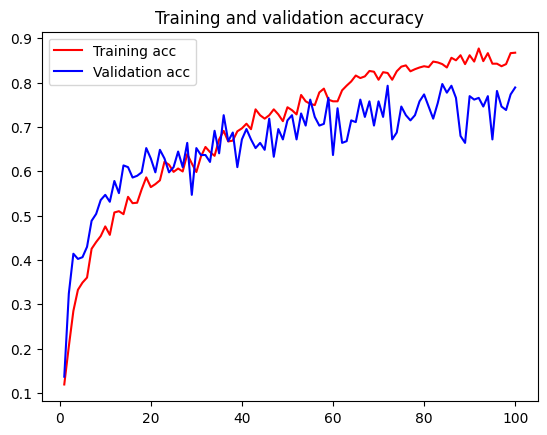

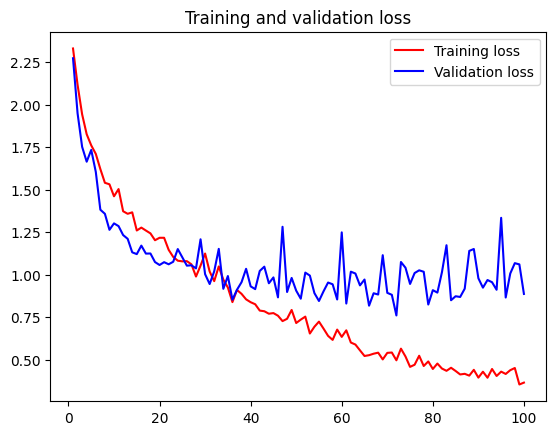

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()